/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer you are loading from './checkpoints/original' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[Info] KLAAD detected as LoRA adapter. Will include it in plots.
Step 1) Computing global vmax (no plotting)...


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


[Global vmax shared across all methods] 0.0273438
Step 2) Plotting all heatmaps with shared color scale...


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


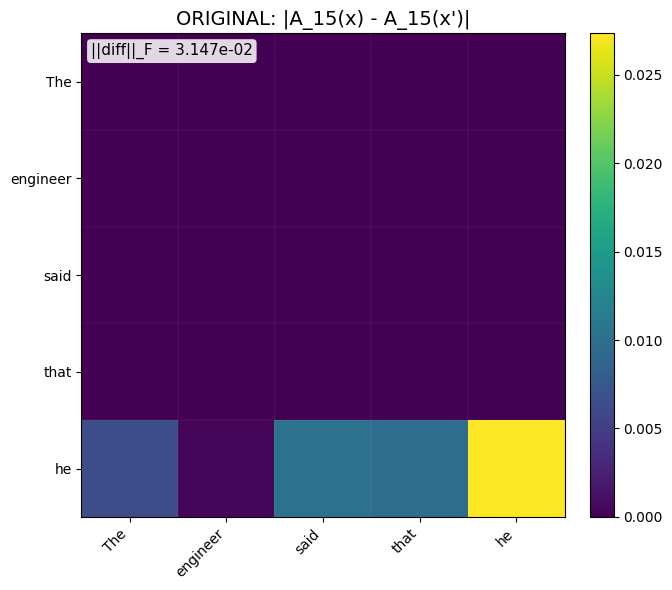

[Saved] ./attn_diff_figs/ORIGINAL_layer15_attn_absdiff_pretty.png


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


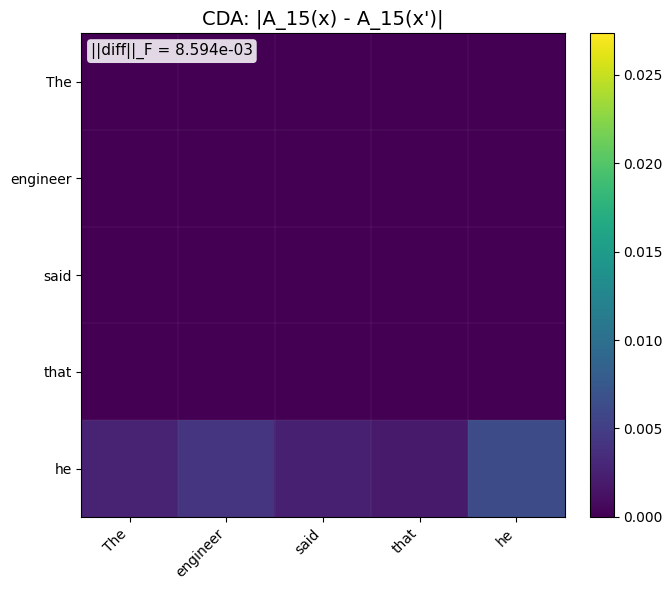

[Saved] ./attn_diff_figs/CDA_layer15_attn_absdiff_pretty.png


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


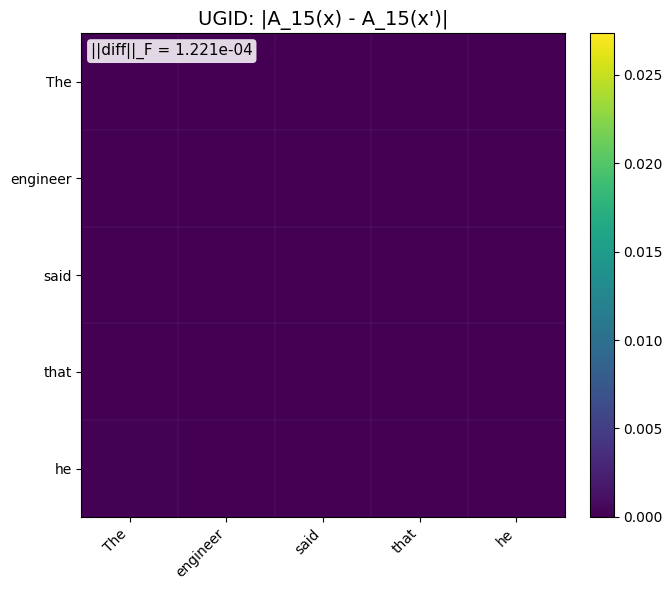

[Saved] ./attn_diff_figs/UGID_layer15_attn_absdiff_pretty.png


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


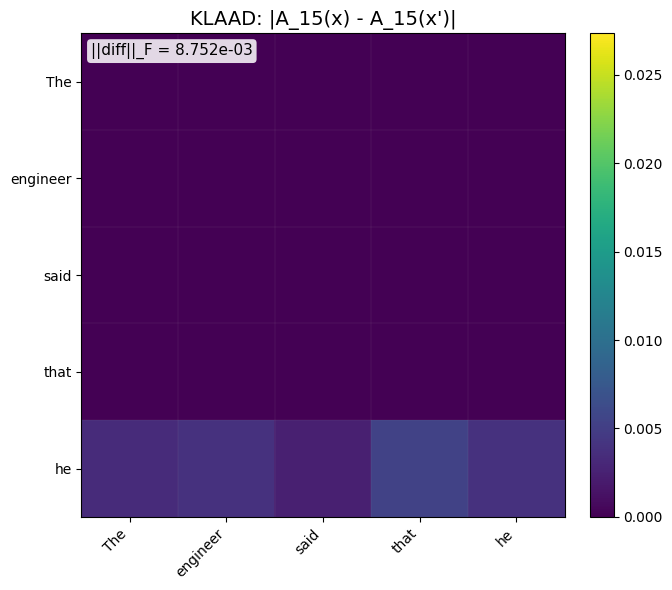

[Saved] ./attn_diff_figs/KLAAD_layer15_attn_absdiff_pretty.png
Done.


In [7]:
import os
import re
import gc
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) 路径配置
# =========================
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")   # <- 自动检测是否存在/是否为LoRA

# 反事实对（跟你训练/评测一致）
x  = "The engineer said that he"
xp = "The engineer said that she"

# 画哪一层
LAYER_IDX = 15

# 输出目录
OUT_DIR = "./attn_diff_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# 1) tokenizer
# =========================
tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# =========================
# 2) 模型加载
# =========================
def load_original_full():
    model = AutoModelForCausalLM.from_pretrained(
        ORIG_DIR,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        output_attentions=True,
        attn_implementation="eager",
    )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    """
    以 original 全量为 base，再挂 LoRA adapter（adapter_dir 里应有 adapter_model.safetensors / adapter_config.json）
    """
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

# =========================
# 3) attention 提取
# =========================
@torch.no_grad()
def get_layer_attention_mean(model, text: str, layer_idx: int):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inputs, output_attentions=True)
    attn = out.attentions[layer_idx]     # [B,H,S,S]
    attn = attn[0].mean(dim=0)           # [S,S] head-mean
    input_ids = inputs["input_ids"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return attn, tokens

def _pretty_token(t: str) -> str:
    # 去掉常见BPE前缀，让token更像自然语言
    t = t.replace("Ġ", "").replace("▁", "")
    return t

def _is_special_token(t: str) -> bool:
    # 过滤 <|begin_of_text|> / <s> / </s> / <...> 这类
    if re.match(r"^<\|.*\|>$", t):
        return True
    if re.match(r"^<.*>$", t):
        return True
    return False

def _filter_and_align(attn_x, tok_x, attn_xp, tok_xp):
    """
    - 两句长度裁到最短
    - 去掉特殊token
    - 返回对齐后的 attn_x, attn_xp, tokens
    """
    S = min(attn_x.shape[0], attn_xp.shape[0])
    attn_x  = attn_x[:S, :S]
    attn_xp = attn_xp[:S, :S]
    tok_x   = tok_x[:S]

    keep = [i for i, t in enumerate(tok_x) if not _is_special_token(t)]
    if len(keep) == 0:
        keep = list(range(S))

    attn_x  = attn_x[keep][:, keep]
    attn_xp = attn_xp[keep][:, keep]
    tokens  = [_pretty_token(tok_x[i]) for i in keep]

    return attn_x, attn_xp, tokens

# =========================
# 4) 绘图（统一尺度 + 更美观 + 数值标注）
# =========================
def plot_heatmap(diff, tokens, title, save_path, vmin=0.0, vmax=None):
    diff_cpu = diff.detach().float().cpu()
    fro = torch.norm(diff_cpu, p="fro").item()

    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    im = ax.imshow(diff_cpu, vmin=vmin, vmax=vmax, cmap="Blues", interpolation="nearest", aspect="equal")  # 不指定cmap，默认即可

    ax.set_title(title, fontsize=14)

    S = len(tokens)
    ax.set_xticks(range(S))
    ax.set_yticks(range(S))
    ax.set_xticklabels(tokens, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(tokens, fontsize=10)

    # 轻量网格（更“论文风”）
    ax.set_xticks([i - 0.5 for i in range(1, S)], minor=True)
    ax.set_yticks([i - 0.5 for i in range(1, S)], minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.3, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # 数值证据（论文里非常好用）
    ax.text(
        0.02, 0.98,
        f"||diff||_F = {fro:.3e}",
        transform=ax.transAxes,
        va="top", ha="left",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85, linewidth=0.0)
    )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)

# =========================
# 5) 计算 diff（可选择是否绘图）
# =========================
@torch.no_grad()
def compute_diff_for_model(model):
    A_x,  tok_x  = get_layer_attention_mean(model, x,  LAYER_IDX)
    A_xp, tok_xp = get_layer_attention_mean(model, xp, LAYER_IDX)
    A_x, A_xp, tokens = _filter_and_align(A_x, tok_x, A_xp, tok_xp)
    diff = (A_x - A_xp).abs()
    return diff, tokens

def compute_and_maybe_plot(method_name: str, loader_fn, vmin, vmax, do_plot: bool):
    model = loader_fn()
    diff, tokens = compute_diff_for_model(model)

    # 清理显存（很关键）
    del model
    gc.collect()
    torch.cuda.empty_cache()

    if do_plot:
        save_path = os.path.join(OUT_DIR, f"{method_name}_layer{LAYER_IDX}_attn_absdiff_pretty.png")
        title = f"{method_name}: |A_{LAYER_IDX}(x) - A_{LAYER_IDX}(x')|"
        plot_heatmap(diff, tokens, title, save_path, vmin=vmin, vmax=vmax)
        print(f"[Saved] {save_path}")

    return diff

# =========================
# 6) 主流程：先算 global vmax（不画），再统一画图
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]

# 可选加入 KLAAD
if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Will include it in plots.")
else:
    print("[Info] KLAAD not found as LoRA adapter dir (missing adapter_config/model). Skipping KLAAD.")

print("Step 1) Computing global vmax (no plotting)...")
diffs = []
for name, loader in METHODS:
    d = compute_and_maybe_plot(name, loader, vmin=0.0, vmax=1.0, do_plot=False)
    diffs.append(d)

global_vmax = max(d.max().item() for d in diffs) + 1e-12
print(f"[Global vmax shared across all methods] {global_vmax:.6g}")

# 释放diffs（可选）
del diffs
gc.collect()

print("Step 2) Plotting all heatmaps with shared color scale...")
for name, loader in METHODS:
    compute_and_maybe_plot(name, loader, vmin=0.0, vmax=global_vmax, do_plot=True)

print("Done.")

/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer you are loading from './checkpoints/Llama-3-8B/original' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Step 1: Computing Max Scale (vmax) ---
Loading ORIGINAL...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


Loading CDA...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Loading UGID...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Loading KLAAD...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Global Max Scale: 0.0287
--- Step 2: Plotting ---
Loading ORIGINAL...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


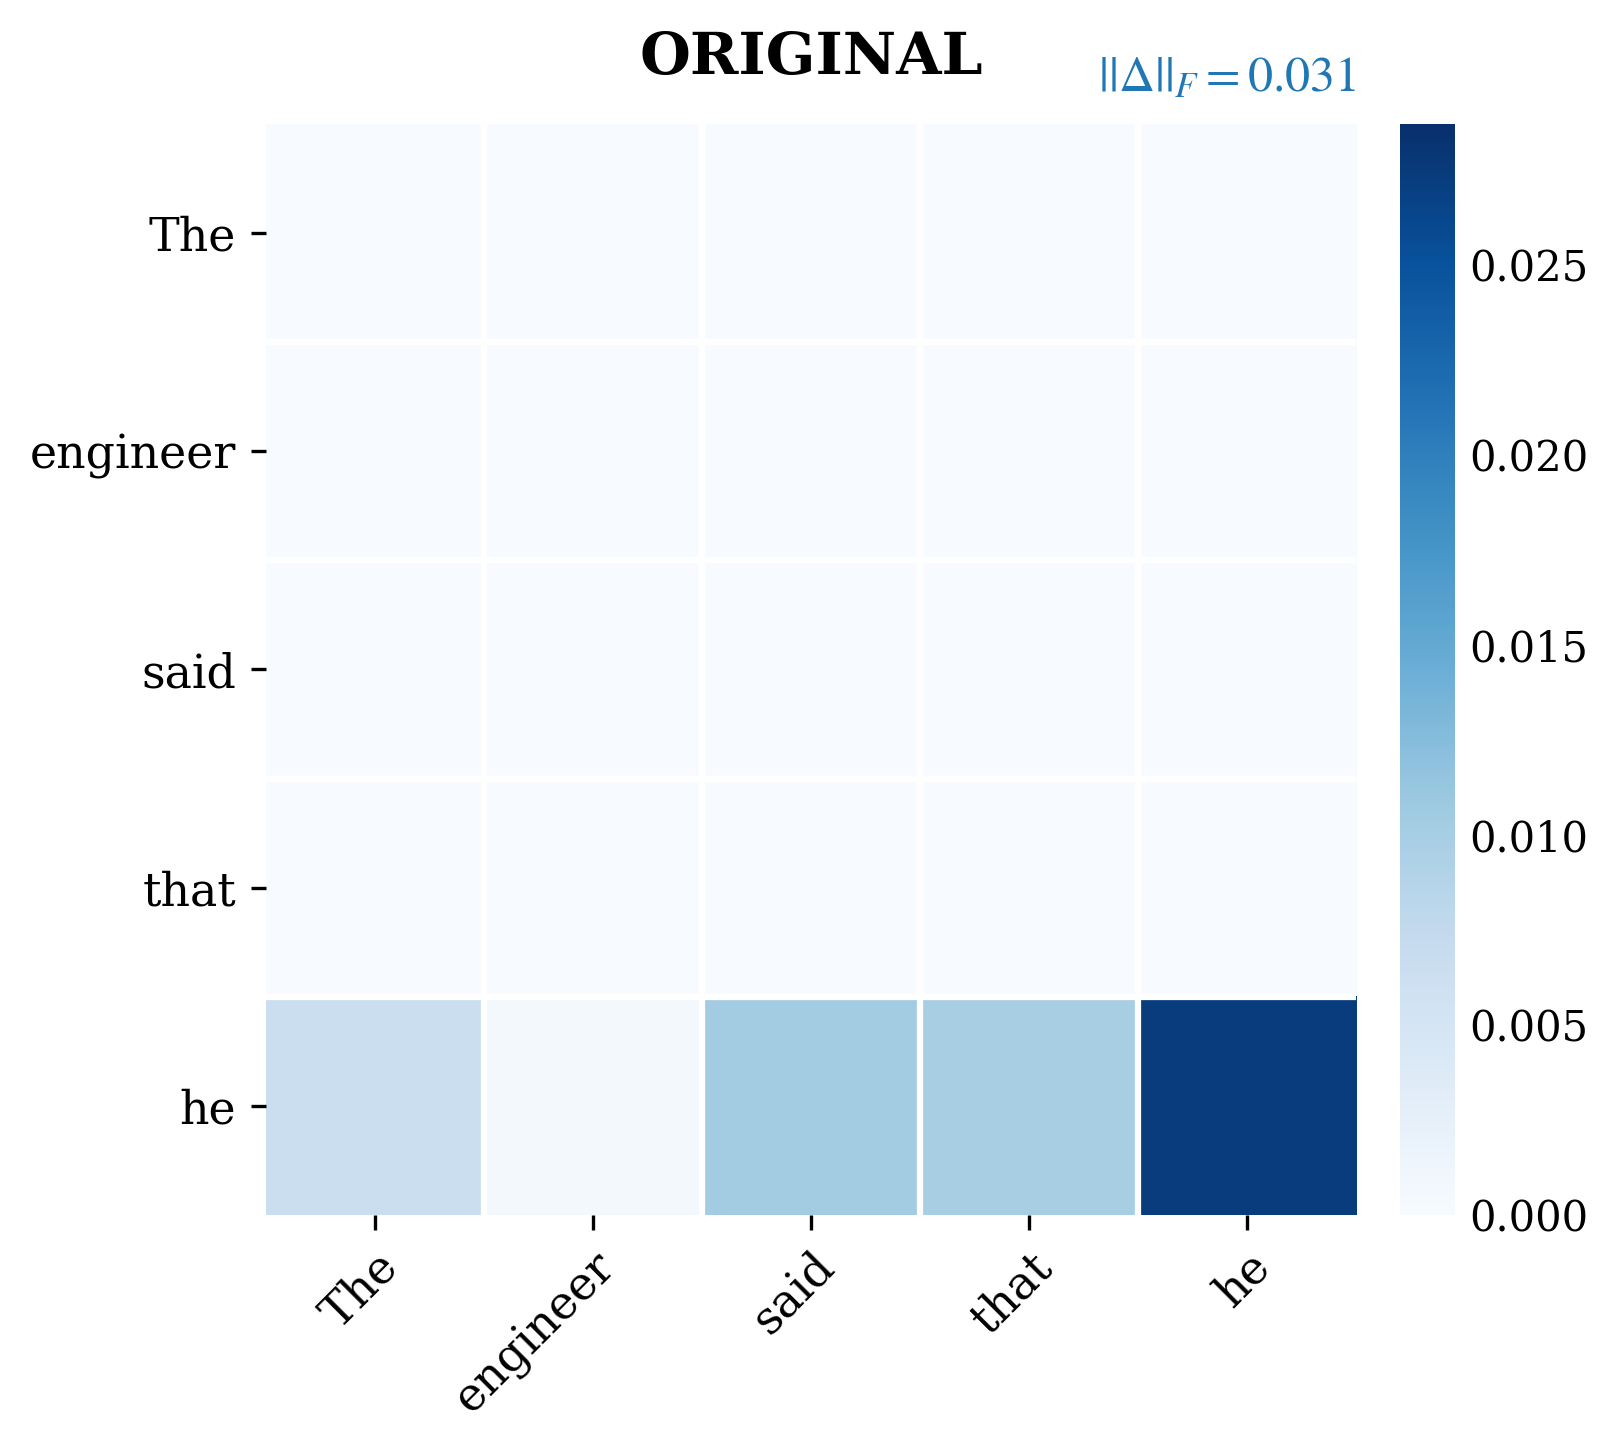

[Saved] ./attn_diff_figs/ORIGINAL_L15_AttentionDiff.png
Loading CDA...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


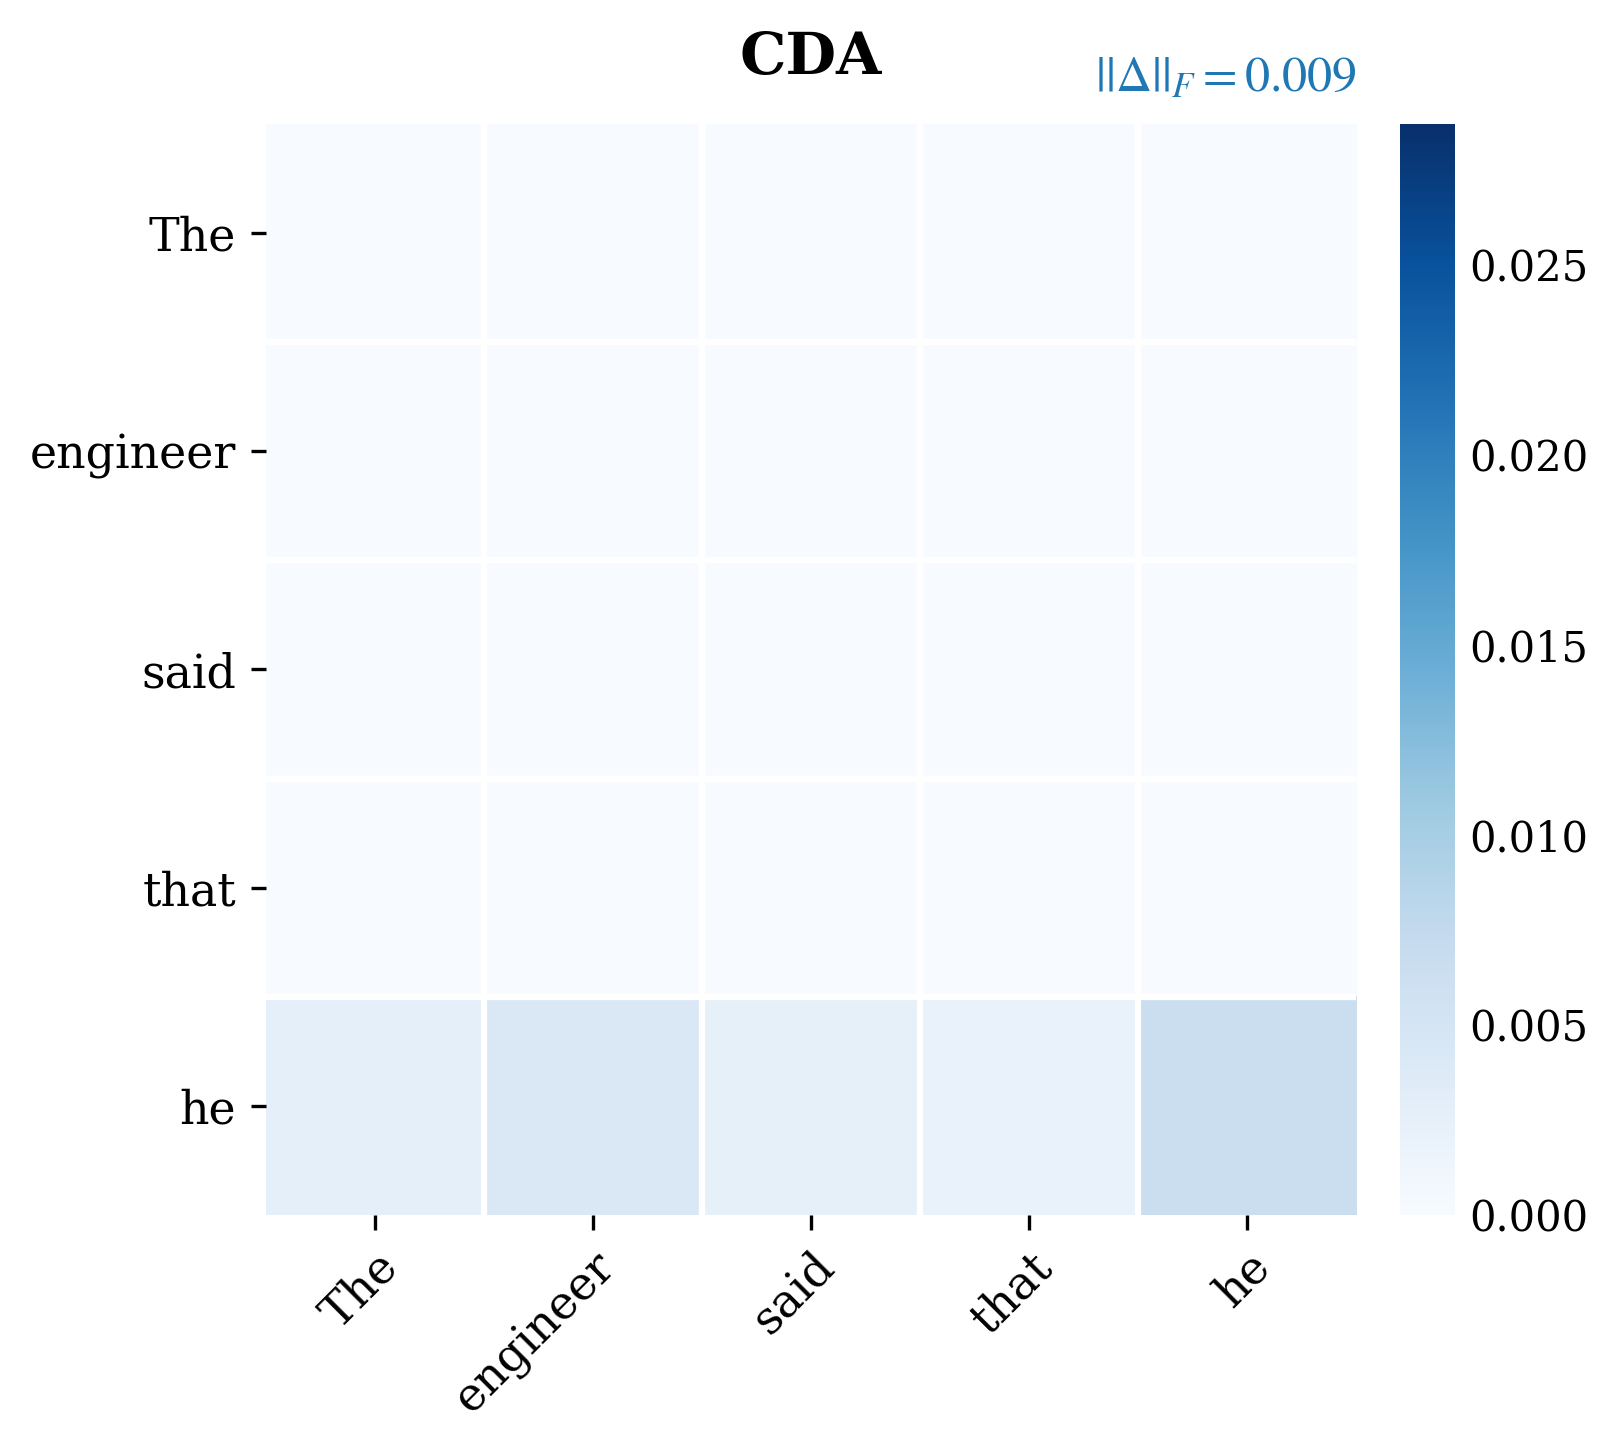

[Saved] ./attn_diff_figs/CDA_L15_AttentionDiff.png
Loading UGID...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


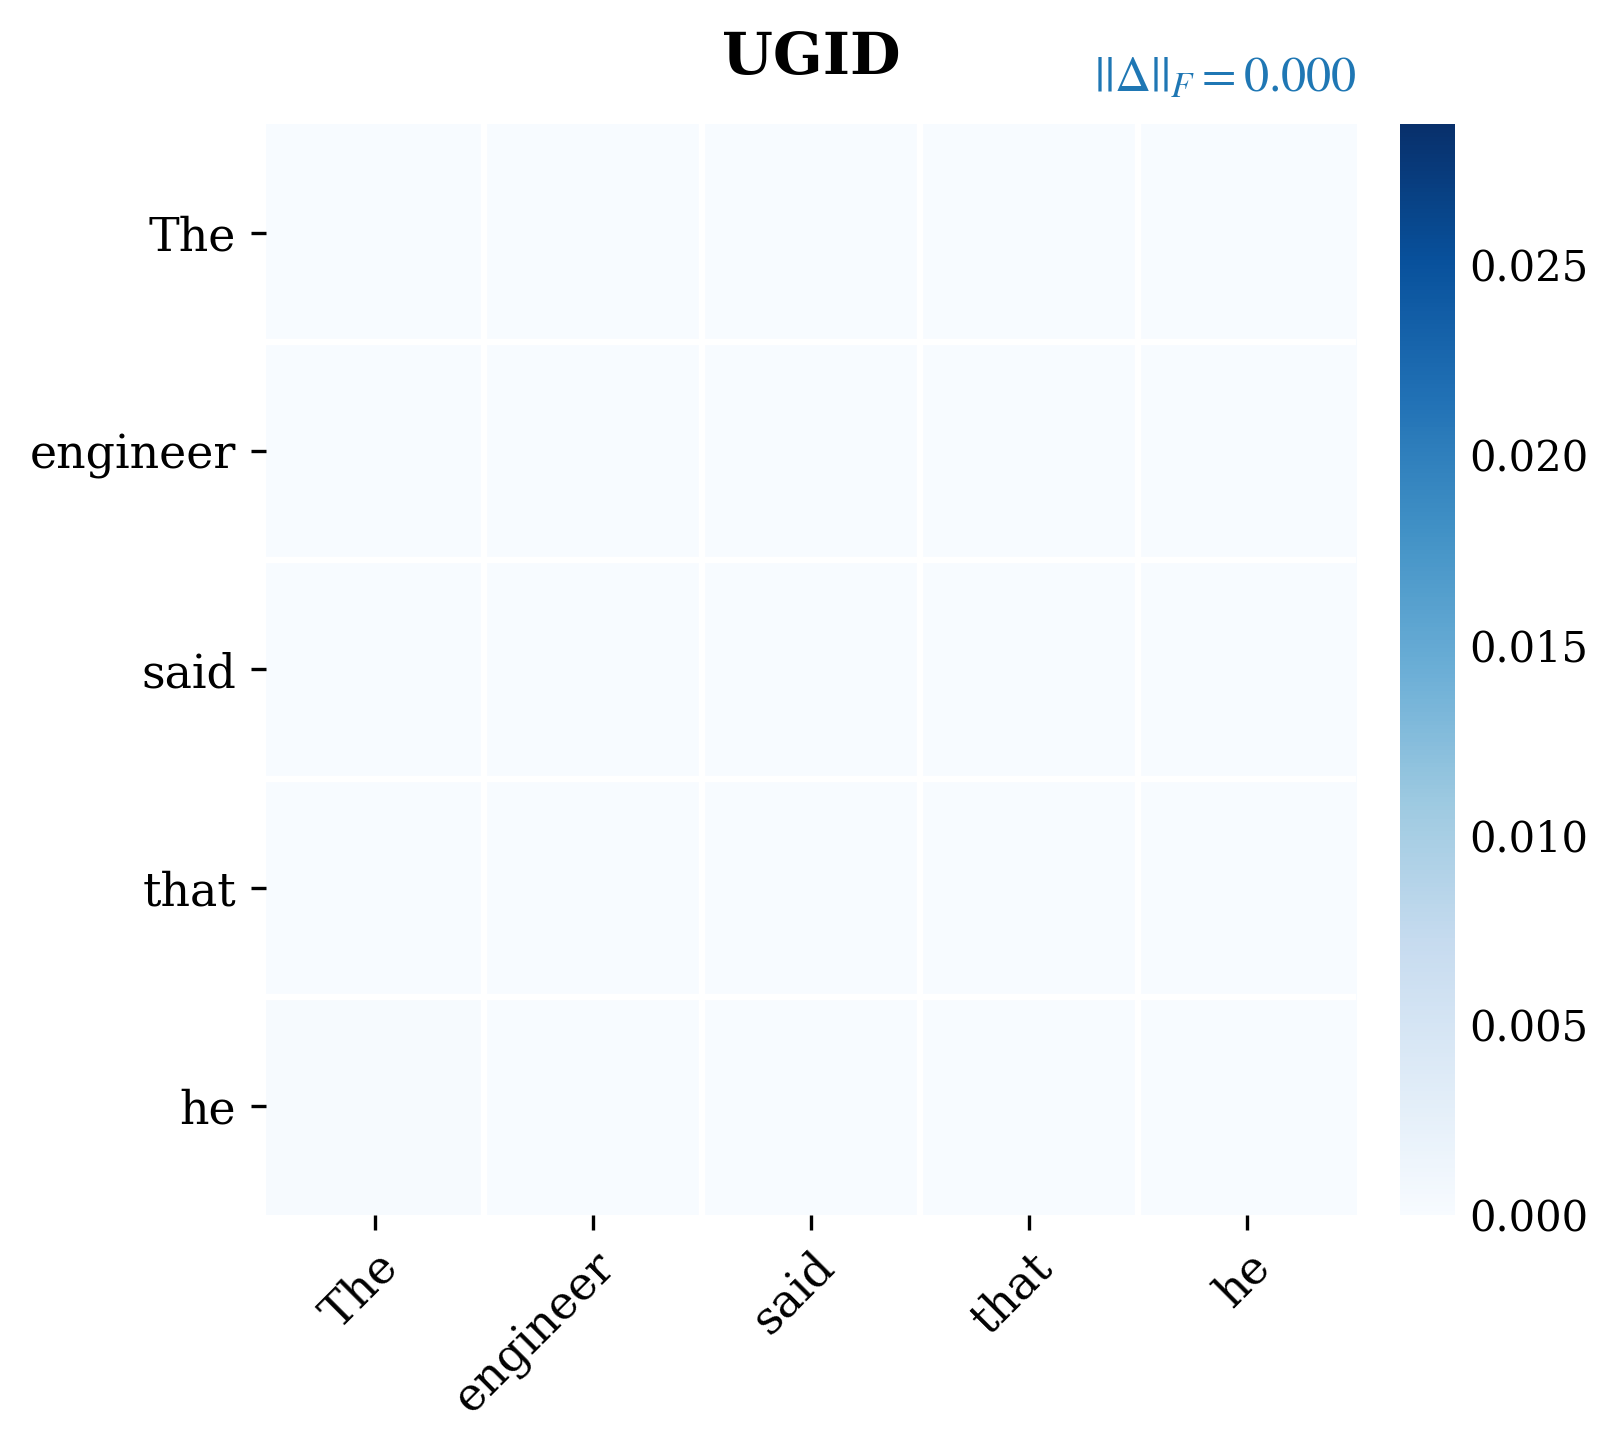

[Saved] ./attn_diff_figs/UGID_L15_AttentionDiff.png
Loading KLAAD...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


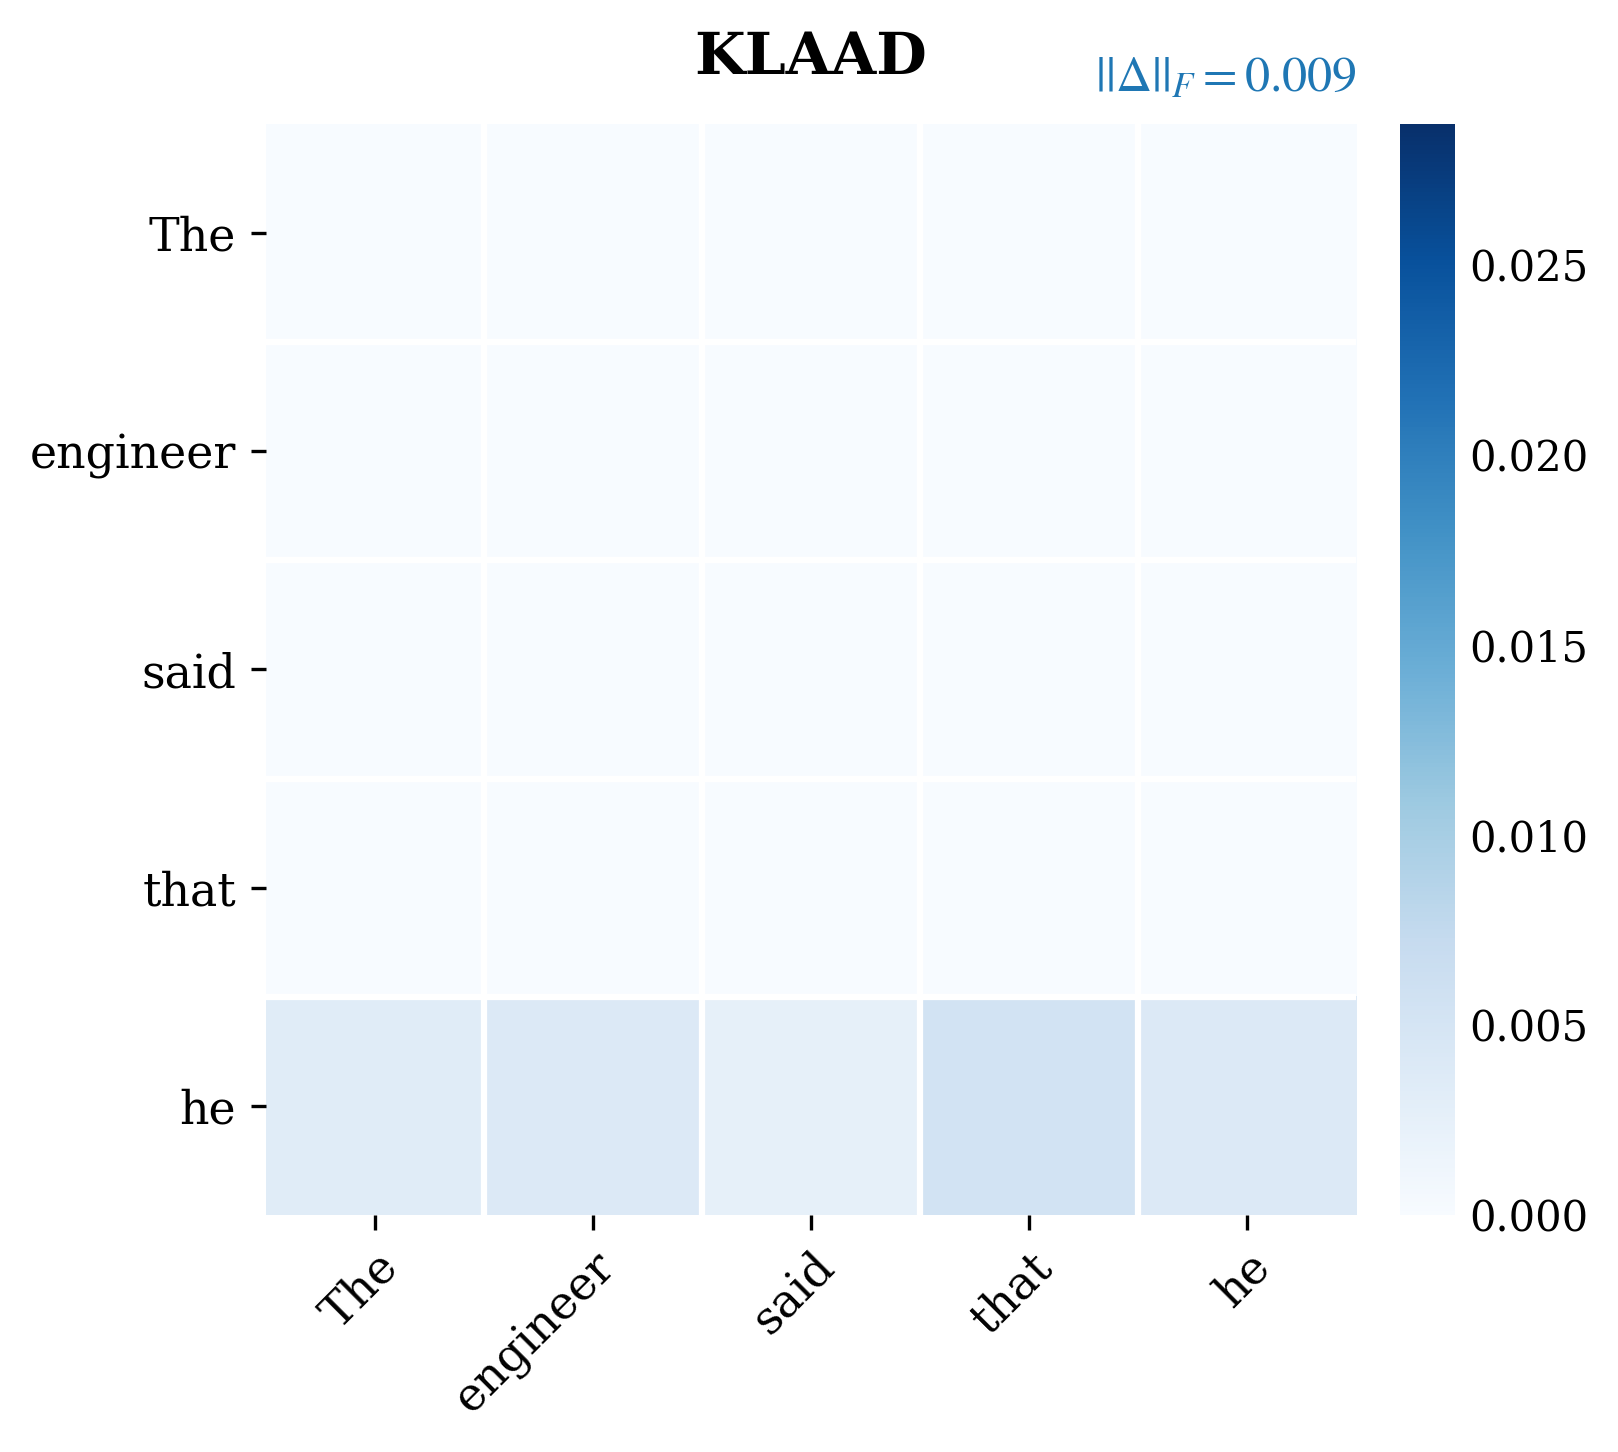

[Saved] ./attn_diff_figs/KLAAD_L15_AttentionDiff.png
Done.


In [1]:
import os
import re
import gc
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) 全局样式配置 (ICML Style)
# =========================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 300,
    "mathtext.fontset": "stix",
})

# =========================
# 路径配置
# =========================
CKPT_ROOT = "./checkpoints/Llama-3-8B" # 确保路径正确
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid") # 假设目录名是这个
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")

# 观察哪一层
LAYER_IDX = 15

# 反事实对
x  = "The engineer said that he"
xp = "The engineer said that she"

OUT_DIR = "./attn_diff_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# 1) Tokenizer
# =========================
tokenizer = AutoTokenizer.from_pretrained(
    ORIG_DIR, 
    use_fast=True, 
    local_files_only=True
)
tokenizer.pad_token = tokenizer.eos_token

# =========================
# 2) 模型加载
# =========================
def load_original_full():
    model = AutoModelForCausalLM.from_pretrained(
        ORIG_DIR,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        output_attentions=True,
        attn_implementation="eager",
        local_files_only=True
    )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

# =========================
# 3) Attention 提取逻辑
# =========================
@torch.no_grad()
def get_layer_attention_mean(model, text: str, layer_idx: int):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inputs, output_attentions=True)
    attn = out.attentions[layer_idx]     # [B,H,S,S]
    attn = attn[0].mean(dim=0)           # [S,S] head-mean
    input_ids = inputs["input_ids"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return attn, tokens

def _pretty_token(t: str) -> str:
    # 清洗 token 显示
    t = t.replace("Ġ", "").replace("▁", "")
    return t

def _is_special_token(t: str) -> bool:
    if re.match(r"^<\|.*\|>$", t): return True
    if re.match(r"^<.*>$", t):     return True
    return False

def _filter_and_align(attn_x, tok_x, attn_xp, tok_xp):
    S = min(attn_x.shape[0], attn_xp.shape[0])
    attn_x  = attn_x[:S, :S]
    attn_xp = attn_xp[:S, :S]
    tok_x   = tok_x[:S]

    keep = [i for i, t in enumerate(tok_x) if not _is_special_token(t)]
    if len(keep) == 0:
        keep = list(range(S))

    attn_x  = attn_x[keep][:, keep]
    attn_xp = attn_xp[keep][:, keep]
    tokens  = [_pretty_token(tok_x[i]) for i in keep]

    return attn_x, attn_xp, tokens

# =========================
# 4) [核心修改] 绘图函数：浅色系 + 现代学术风
# =========================
def plot_heatmap(diff, tokens, method_name, save_path, vmin=0.0, vmax=None):
    diff_cpu = diff.detach().float().cpu()
    fro = torch.norm(diff_cpu, p="fro").item()

    # 画布大小
    fig, ax = plt.subplots(figsize=(6, 5))

    # 1. 绘制热力图
    # cmap="Blues": 0是白色，值越大越蓝，非常清爽
    im = ax.imshow(diff_cpu, vmin=vmin, vmax=vmax, cmap="Blues", aspect="equal")

    # 2. 坐标轴设置
    S = len(tokens)
    ax.set_xticks(range(S))
    ax.set_yticks(range(S))
    
    # X轴标签旋转45度，对齐方式为 right，这样不会挤在一起
    ax.set_xticklabels(tokens, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(tokens)

    # 3. 美化网格 (白色网格线切割色块)
    # 这种 Tile 风格在 CV 和 NLP 的 Attention 可视化中很流行
    ax.set_xticks([x - 0.5 for x in range(1, S)], minor=True)
    ax.set_yticks([y - 0.5 for y in range(1, S)], minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False) # 隐藏 minor ticks

    # 4. 去除周围的黑色方框 (Spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 5. Colorbar (极简风)
    # outline设为 False 去掉 colorbar 的黑框
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=10, length=0) # 刻度线也去掉

    # 6. 标题与数值标注
    # 左上角：方法名
    ax.set_title(method_name, fontsize=14, fontweight="bold", pad=12, loc='center')

    # 右上角 (或图外)：Frobenius Norm 分数
    # 用 LaTeX 格式写数学符号，蓝色字体呼应主题
    ax.text(
        1.0, 1.02, 
        f"$||\Delta||_F = {fro:.3f}$", 
        transform=ax.transAxes, 
        ha="right", va="bottom",
        fontsize=12, color="#1f77b4", fontweight="bold"
    )

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# =========================
# 5) 计算逻辑
# =========================
@torch.no_grad()
def compute_diff_for_model(model):
    A_x,  tok_x  = get_layer_attention_mean(model, x,  LAYER_IDX)
    A_xp, tok_xp = get_layer_attention_mean(model, xp, LAYER_IDX)
    A_x, A_xp, tokens = _filter_and_align(A_x, tok_x, A_xp, tok_xp)
    diff = (A_x - A_xp).abs()
    return diff, tokens

def compute_and_maybe_plot(method_name: str, loader_fn, vmin, vmax, do_plot: bool):
    print(f"Loading {method_name}...")
    model = loader_fn()
    diff, tokens = compute_diff_for_model(model)

    del model
    gc.collect()
    torch.cuda.empty_cache()

    if do_plot:
        # 保存文件名更规范
        save_path = os.path.join(OUT_DIR, f"{method_name}_L{LAYER_IDX}_AttentionDiff.png")
        plot_heatmap(diff, tokens, method_name, save_path, vmin=vmin, vmax=vmax)
        print(f"[Saved] {save_path}")

    return diff

# =========================
# 6) 主程序
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]

if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))

print("--- Step 1: Computing Max Scale (vmax) ---")
diffs = []
for name, loader in METHODS:
    # 第一次跑只为了算最大值，不画图
    d = compute_and_maybe_plot(name, loader, vmin=0, vmax=1, do_plot=False)
    diffs.append(d)

# 计算全局统一的最大值，保证所有图颜色标尺一致，才能互相比较
global_vmax = max(d.max().item() for d in diffs)
#稍微加一点余量，防止最大值被截断
global_vmax = global_vmax * 1.05 
print(f"Global Max Scale: {global_vmax:.4f}")

del diffs
gc.collect()

print("--- Step 2: Plotting ---")
for name, loader in METHODS:
    compute_and_maybe_plot(name, loader, vmin=0.0, vmax=global_vmax, do_plot=True)

print("Done.")